#Modelo detector de toxicidad multiling√ºe (espa√±ol, ingl√©s, franc√©s) en _tweets_ y art√≠culos de noticias entrenado mediante _fine-tuning_

Autor: Alba Mar√≠a Garc√≠a Garc√≠a

Fecha: 28-Nov-2023

<u>Recursos</u>:
- Datos en _train_ y _test_ en formato CSV.

<u>Requisitos</u>:
- Python >= 3.7
- Realizar un an√°lisis descriptivo de los datos.
- Sin restricciones en el preprocesado.
- Se entregan datos de para el entrenamiento, pero se pueden modificar o utilizar otros.
- Realizar entrenamiento mediante _fine-tuning_.
- El modelo debe funcionar como m√≠nimo en los idiomas espa√±ol, ingl√©s y franc√©s.
- La evaluaci√≥n final se debe hacer sobre los datos de _test_ entregados.
- Realizar un an√°lisis de errores sobre el conjunto de _test_ (sesgos, etc).
- Subir el _notebook_ a un repositorio de GitHub p√∫blico.

<u>Cuestiones</u>:
- ¬øSer√≠a buena idea resolver este problema usando un LLM?

## Preparaci√≥n del entorno

Comprobamos que la versi√≥n nativa de Python de Google Colab es superior a 3.7.

In [1]:
!python --version

Python 3.10.12


Clonamos el repositorio de GitHub donde he subido los recursos de la prueba, los requisitos (librer√≠as) y las constantes y funciones auxiliares (_utils_). Estas √∫ltimas se han separado del _notebook_ por legibilidad y limpieza.

In [2]:
!git clone https://github.com/Akvamarin/toxicity_analysis.git

Cloning into 'toxicity_analysis'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 139 (delta 31), reused 12 (delta 12), pack-reused 95
Receiving objects: 100% (139/139), 5.18 MiB | 8.12 MiB/s, done.
Resolving deltas: 100% (62/62), done.


Permitimos que Google Colab tenga acceso a Google Drive para poder cargar all√≠ los _checkpoints_ del entrenamiento y que estos no se pierdan debido a alg√∫n reinicio de sesi√≥n por haberlos guardado en local.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalamos todas las librer√≠as (dependencias) definidas en requirements.txt.

In [4]:
!pip install -r toxicity_analysis/requirements.txt

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 53.4/53.4 kB 1.7 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.3/1.3 MB 32.9 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 235.5/235.5 kB 27.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 175.4/175.4 kB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=f1571c034b51cb79cd8662061ada6a1f7d36b5f7c59c46d1a795d039704b77ad
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: wcwidth
 

##Preparaci√≥n y limpieza de los datos

In [5]:
import os
import pandas as pd

from toxicity_analysis.utils.constants import REPO_NAME, ID, TEXT, LABEL, ORIGIN, ID_TYPE, ENGLISH, FRENCH

Cargamos los dataset de _train_ y _test_ en sus respectivos DataFrame a partir de sus _path_ en el repositorio de GitHub, no sin antes definir los tipos de cada una de sus variables manualmente para evitar que lo haga Pandas autom√°ticamente asignando tipos _object_ que pueden producir errores de compatibilidad y degradar el rendimiento.

In [6]:
# State train and test dataset paths
train_path = os.path.join(os.getcwd(), REPO_NAME, 'data', 'toxicity_train_augmented_senior_20231102.csv')
test_path = os.path.join(os.getcwd(), REPO_NAME, 'data', 'toxicity_test_augmented_senior_20231102.csv')

# [Sanity check] State the expected data types
data_types = {
      ID: 'string',
      TEXT: 'string',
      LABEL: 'uint8',
      ORIGIN: 'string',
      ID_TYPE: 'string',
      ENGLISH: 'string',
      FRENCH: 'string'
}

# Load train and test data to a DataFrame (assuming encoding UTF-8)
# We'll review data encoding more in detail later on
df_train_val = pd.read_csv(train_path, encoding='utf-8', dtype=data_types)
df_test = pd.read_csv(test_path, encoding='utf-8', dtype=data_types)

# Validate that there are no missing columns
assert df_train_val.shape[-1] == df_test.shape[-1], f"Both datasets must have the same number of columns.\n"\
                                                    f"TRAIN cols: {df_train_val.shape[-1]}, TEST cols: {df_test.shape[-1]}"

# Get datasets' shape
print(f"TRAIN shape: {df_train_val.shape}. TEST shape: {df_test.shape}")

TRAIN shape: (11000, 7). TEST shape: (5000, 7)


Tenemos **11.000 ejemplos de texto en _train_ y 5.000 en _test_**. Se trata de un dataset de entrenamiento bastante reducido, aunque esto no es tan relevante cuando no vamos a realizar un entrenamiento desde cero.

In [7]:
from toxicity_analysis.utils.analysis_utils import style_dataframe

Mostramos las cinco primeras filas de los datos de entrenamiento haciendo uso de la funci√≥n "style_dataframe", creada para mostrar los DataFrame de forma m√°s _est√©tica_ y conveniente.

In [8]:
# Show the first five rows
style_dataframe(df_train_val)

Podemos observar que la estructura de los datos es acorde con la descripci√≥n del enunciado, pero tambi√©n que existen dos problemas:
- Existe un **problema de codificaci√≥n generalizado**. A pesar de haber cargado los datos usando encoding='utf-8', no se muestran correctamente los caracteres acentuados ni los emojis (probablemente la letra "√±" tampoco). Es posible que los textos estuvieran ya corruptos de antemano.
- **Las traducciones** en los campos "english" y "french" **no siempre corresponden con el texto que aparece en "text"**. De todas formas, no supone ning√∫n problema siempre que no est√©n mezcladas traducciones de contenido t√≥xico en entradas no t√≥xicas y viceversa.

Antes de continuar con estos problemas, vamos a comprobar si existen _missing values_ en los datos de entrenamiento y test.

In [9]:
# Find if there are missing values
print(f"TRAIN missing values:\n\n{df_train_val.isna().sum()}")

TRAIN missing values:

id            0
text          0
label         0
origin        0
id-type       0
english    1040
french     1041
dtype: int64


In [10]:
print(f"TEST missing values:\n\n{df_test.isna().sum()}")

TEST missing values:

id          0
text        0
label       0
origin      0
id-type     0
english    13
french     10
dtype: int64


Observamos que **s√≥lo existen _missing values_ en los campos "english" y "french"** (traducciones). Esto no supone ning√∫n problema porque en el futuro dataset de entrenamiento, las traducciones ser√°n independientes de sus textos originales y en los casos que no existan, ser√°n simplemente ignoradas.

Ahora, procedemos a resolver el problema de la codificaci√≥n incorrecta.

In [11]:
import chardet

In [12]:
# Let's check if chardet shares our opinion about UTF-8 encoding just in case
with open(train_path, 'rb') as f:
  # Read the first 10K bytes to get a charset guess
  sample_bytes = f.read(10000)
  # Infer the charset
  inferred_charset = chardet.detect(sample_bytes)

print(f"Inferred encoding: {inferred_charset['encoding']} (confidence: {inferred_charset['confidence']})")

Inferred encoding: utf-8 (confidence: 0.99)


Volvemos a leer el fichero de entrenamiento, pero esta vez en modo binario, es decir, como _bytes_ en lugar de cadenas de texto para evitar forzar ning√∫n tipo de codificaci√≥n y poder **conocer su codificaci√≥n nativa**. Dicha codificaci√≥n ha resultado ser la previamente asumida <u>UTF-8</u>, por lo que podemos confirmar que, efectivamente, **los datos estaban corruptos**.

Procedemos, por tanto a _limpiar_ el texto mediante la librer√≠a ftfy.

In [13]:
import ftfy
from pandas import NA

In [14]:
# We can conclude that decoding errors are not coming from an incorrect charset.
# Thus, we proceed to correct them in both data splits (train and test)

input_text_columns = [TEXT, ENGLISH, FRENCH]  # Affected columns

# Define the cast function to correct these errors, letting missing values as they are
cast_func = lambda text: str(ftfy.fix_text(text)) if text is not NA else text

# Apply this correction to both datasets
for column in input_text_columns:
  df_train_val[column] = df_train_val[column].apply(cast_func).astype('string')
  df_test[column] = df_test[column].apply(cast_func).astype('string')

In [15]:
# Show the data again to make sure data corruption has been corrected
style_dataframe(df_train_val)

Podemos comprobar que han aparecidos las tildes y los emojis, <u>estos textos ya s√≠ son legibles sin dificultad</u>. Finalmente, comprobemos que el texto no presenta caracteres indeseados como pueden ser Ôøº o ÔøΩ.

In [16]:
texts_with_missing_characters = {}
# Look for other replacement characters due to unicode decode errors
for symbol in ('Ôøº', 'ÔøΩ'):
    texts_with_missing_characters[symbol] = df_train_val[df_train_val['text'].str.contains(symbol)]

In [17]:
print("Character OBJ\n")
style_dataframe(texts_with_missing_characters['Ôøº'])

Character OBJ



In [18]:
print("Character ÔøΩ\n")
style_dataframe(texts_with_missing_characters['ÔøΩ'])

Character ÔøΩ



Comprobamos que no hay ninguna incidencia con el caracter Ôøº, pero s√≠ con el caracter ÔøΩ. De todas formas, se trata de un problema aislado de las noticias de la web "kioskoymas.abc.es" y se puede solucionar manualmente. (Normalmente, este tipo de errores de decodificaci√≥n no son tan sencillos de resolver como los anteriores).

In [19]:
# As they are just four erroneous entries, we can directly fix them manually
# (There is no clear simple and escalable solution for this)
corrected_texts = [
    "Hondo e inspirado, el matador madrile√±o charla con ABC desde su retiro en el campo extreme√±o, donde prepara su en√©simo examen en Las Ventas.",
    "La Consejer√≠a de Cultura y Turismo mostr√≥ ayer su voluntad de desarrollar una segunda fase de los programas de restauraci√≥n, conservaci√≥n, difusi√≥n y divulgaci√≥n 'Zamora Rom√°nica' y 'Rom√°nico Atl√°ntico', dos planes de actuaci√≥n sobre templos en los que participa la Junta de Castilla y Le√≥n con el fin de salvaguardar el patrimonio.",
    "SUSANA D√≠az dio ayer el primer paso para ser investida presidenta andaluza.",
    "En este caso es JAVIER DEL CERRO quien nos reprocha que, como seguidor de su web, motorista y apasionado a las motos, me parece algo incre√≠ble."
]

# Update the DataFrame with the correct texts
df_train_val.loc[texts_with_missing_characters['ÔøΩ'].index, TEXT] = corrected_texts

assert (df_train_val['text'].str.contains('ÔøΩ') == False).all(), f"There are still ÔøΩ symbols within the data."
style_dataframe(df_train_val.loc[texts_with_missing_characters['ÔøΩ'].index])

Comprobamos, finalmente, que **todos los problemas de decodificaci√≥n han desaparecido**.

# An√°lisis descriptivo de los datos

En esta secci√≥n vamos a conocer el balanceo de clases en los datos, as√≠ como el contenido de los mismos en rasgos generales. En un principio, sabemos que √©stos se han obtenido de dos fuentes: Twitter y p√°ginas web de noticias (todo apunta que de car√°cter generalista).

## Balanceo de clases

In [20]:
from toxicity_analysis.utils.analysis_utils import get_norm_crosstab, visualize_norm_crosstab

Para conocer la distribuci√≥n de las clases en nuestro dataset, voy a emplear la _cross tabulation_ o _contingency table_, que no es m√°s que una tabla donde se enfrentan dos variables de un conjunto de datos para mostrar el n√∫mero de ocurrencias para las diferentes combinaciones de valores en ambas variables o s√≥lo en una de ellas. En este caso, las variables objetivo son la clase y el origen de los datos.

In [21]:
# Get cross tabs for both train and test datasets
train_val_crosstab = get_norm_crosstab(df_train_val, rows_label=LABEL, columns_label=ORIGIN)
test_crosstab = get_norm_crosstab(df_test, rows_label=LABEL, columns_label=ORIGIN)

In [22]:
visualize_norm_crosstab(train_val_crosstab, "Crosstab for TRAIN", rows_name=LABEL, columns_name=ORIGIN)

In [23]:
visualize_norm_crosstab(test_crosstab, "Crosstab for TEST", rows_name=LABEL, columns_name=ORIGIN)

Podemos hacer las siguientes observaciones:
- **Los datos est√°n claramente desbalanceados** en ambos casos, aunque especialmente en los datos de _test_: existen m√°s textos no t√≥xicos que t√≥xicos.
- Esto es debido a que los contenidos t√≥xicos provienen de forma pr√°cticamente exclusiva de Twitter (si un texto es t√≥xico, hay un 90-95% de probabilidades que provenga de Twitter). El contenido de los art√≠culos de noticias es abrumadoramente no t√≥xico (alrededor del 97%).
- En resumen, el contenido de Twitter es tanto t√≥xico como no t√≥xico (en proporciones diferentes dependiendo de cu√°ndo se obtuvieron los datos), mientras que el contenido de los art√≠culos de noticias es casi al 100% no t√≥xico.

Por tanto, **a√±adir cualquier informaci√≥n acerca del origen de los datos crear√≠a un sesgo muy fuerte** en el clasificador que no le permitir√≠a generalizar correctamente (¬øQu√© pasa si cambia la distribuci√≥n de los datos y al modelo le empiezan a llegar art√≠culos de noticias muy t√≥xicas? Porque estas noticias tambi√©n existen).

El desbalanceo de clases se puede tratar de dos maneras:
- Aumentando artificialmente los datos de entrenamiento (data augmentation).
- **Ponderando la funci√≥n de _loss_** del modelo durante el entrenamiento de forma proporcionalmente inversa a la distribuci√≥n de clases.

He optado por la segunda por su mayor simplicidad de implementaci√≥n.

##Contenido sem√°ntico de los datos

En esta subsecci√≥n nos vamos a ayudar de la librer√≠as spacy y matplotlib para analizar el **contenido sem√°ntico** de los datos de entrenamiento y _test_. Por limitaci√≥n de tiempo, me he centrado en analizar <u>s√≥lo los contenidos en espa√±ol</u>, ya que son los mayoritarios (no presentan _missing values_) y tambi√©n los principales (los otros son traducciones). Idealmente, habr√≠a realizado la misma prueba para los textos en ingl√©s y franc√©s.

Primero, descargamos la pipeline de entrenamiento de spacy para espa√±ol. He elegido la versi√≥n grande (_lg_) porque no tenemos tantos datos como para que suponga muy pesado de procesar y as√≠ obtenemos la mayor calidad posible.

In [24]:
!python -m spacy download es_core_news_lg

2023-11-29 01:56:00.925872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 01:56:00.925964: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 01:56:00.926017: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 01:56:02.155864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 568.0/568.0 MB 3.1 MB/s eta 0:00:00
‚úî Download and installation successful
You can now load the package via sp

In [25]:
from collections import Counter, defaultdict
from copy import deepcopy
from typing import Dict

import spacy
from spacy.tokens import Doc

from tqdm import tqdm
import matplotlib.pyplot as plt

from toxicity_analysis.utils.constants import TOXIC, NON_TOXIC, TWITTER, NEWS, TRAIN, TEST

Al igual que hicimos en el an√°lisis de balanceo de clases, vamos a dividir los datos por origen y por _label_, para conocer el contenido segmentado por las variables m√°s relevantes. Lo primero que vamos a hacer es procesar todas las palabras de ambos dataset (_train_ y _test_) mediante el modelo de lenguaje de spacy para espa√±ol que hemos descargado previamente (esto puede tardar unos minutos).

In [26]:
# Load spacy's Spanish training pipeline
nlp = spacy.load('es_core_news_lg')

# Define the data structure for each dataset (dict)
data_structure = {
    TOXIC: {
        TWITTER: [],
        NEWS: []
    },
    NON_TOXIC: {
        TWITTER: [],
        NEWS: []
    }
}

# Define the variable where all data will be located: 'processed_words'
processed_words = {data: deepcopy(data_structure) for data in [TRAIN, TEST]}
data_analysis_vars = [TEXT, LABEL, ORIGIN]  # Target variables
datasets = [(df_train_val, TRAIN), (df_test, TEST)]

for dataset, data_split in datasets:  # For every dataset
    # Process all words using spacy's language model (it can take several minutes -> tqdm to see progress)
    for _, entry in tqdm(dataset[data_analysis_vars].iterrows(), desc=f'Processing words ({data_split})', total=len(dataset)):

      # Assert label and origin values are as expected
      assert entry[LABEL] in [0, 1], f"Label variable must be either 0 or 1. Got {entry[LABEL]}."
      assert entry[ORIGIN] in [TWITTER, NEWS], f"Origin variable must be either {TWITTER} or {NEWS}."

      label = TOXIC if entry[LABEL] == 1 else NON_TOXIC
      origin = TWITTER if entry[ORIGIN] == TWITTER else NEWS

      # Store each processed text in their correct location acordint to their origin / label
      processed_words[data_split][label][origin].append(nlp(entry[TEXT]))

    # Finally, assert that each main key of the dict (each data split), has the expected number of values
    total_entries = sum(len(texts_by_origin) for texts_by_label in processed_words[data_split].values() for texts_by_origin in texts_by_label.values())
    assert total_entries == len(dataset), f"Number of entries not matching. Expected: {len(dataset)}. Got: {total_entries}"

Processing words (TEST): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [01:06<00:00, 75.27it/s]


In [27]:
from toxicity_analysis.utils.analysis_utils import get_word_freqs, visualize_word_freqs_by_toxicity_and_origin

Una vez se han procesado las palabras de ambos dataset, obtenemos la **frecuencia de palabras segmentado por su clase y origen**. Para obtener unos resultados m√°s representativos, se han realizado las siguientes acciones:
- Los textos se han puesto en min√∫scula (_lowercase_).
- Se han lematizado las palabras para que una misma conjugaci√≥n o variaci√≥n de g√©nero / n√∫mero no se considere un t√©rmino diferente.
- Se han eliminado las _stopwords_ (palabras muy comunes sin significado sem√°ntico).
- Se han eliminado los signos de puntuaci√≥n y los espacios.

He decidido mantener los emojis porque s√≠ que tienen contenido sem√°ntico.

En las tablas de abajo se muestran las 100 y 50 palabras m√°s frecuentes de los datos de entrenamiento y _test_ respectivamente, ordenadas seg√∫n el **sesgo de clase** para la clase bajo la que aparecen (campo _ratio_) en orden descendente. Por ejemplo, si "miserable" tiene un _ratio_ de 100%, significa que todas las veces que aparece esta palabra es en textos clasificados como "t√≥xicos". Si esta palabra apareciera en alguna de las columnas de la clase "NON-TOXIC", su significado ser√≠a el contrario.

Notar que <u>se filtran las palabras primero por frecuencia para asegurarnos de que los t√©rminos que vemos son relevantes para ese subconjunto de datos</u>. Se pueden ignorar los t√©rminos t√≥xicos de news-articles obtenidos, ya que apenas hay datos como para sacar ninguna conclusi√≥n (se incluy√≥ por simplicidad en la implementaci√≥n).

In [28]:
word_freqs_train = get_word_freqs(processed_words[TRAIN])  # Get word frequencies for train split
global_frequencies_train, styled_df_train = visualize_word_freqs_by_toxicity_and_origin(word_freqs_train)
styled_df_train

¬øQu√© conclusiones podemos sacar acerca del contenido de los datos de entrenamiento?
- Existen diferencias muy significativas entre los textos t√≥xicos y los no t√≥xicos.
- El **contenido t√≥xico** parece ser muy f√°cil de identificar porque en √©l abundan **t√©rminos con elevada <u>connotaci√≥n negativa</u>**. Adem√°s, su contenido est√° <u>muy centrado en la pol√≠tica</u> y apenas parece versar sobre otros temas. Grupos de palabras m√°s relevantes que he podido identificar:
  - <u>Adjetivos de corte pol√≠tico</u>: progre(*), golpista, sectario, separatista, comunista.
  - <u>Adjetivos de corte gen√©rico</u>: miserable, muerto.
  - <u>Sustantivos de corte gen√©rico</u>: verg√ºenza, ruina, mafia, miseria, cloaca, mentira, enemigo, odio.
  - <u>Verbos de corte gen√©rico</u>: mentir.

  (*) "progr" se refiere a "progres" y es generado por la lematizaci√≥n. Al tratarse de una palabra de reciente creaci√≥n, spacy falla al inferir su versi√≥n singular.

- El **contenido** parece estar **muy ideologizado** y tiene un **sesgo claro hacia posiciones m√°s conservadoras** o de "derechas" por el lenguaje empleado (v√©ase los adjetivos de corte pol√≠tico del punto anterior). El partido pol√≠tico con mayor sesgo de toxicidad es Vox por encima del resto y los principales objetivos de los cr√≠ticas parecen ser Pablo Iglesias y Pedro S√°nchez, personajes m√°s destacados del anterior gobierno de coalici√≥n, as√≠ como la extinta organizaci√≥n terrorista ETA (que sigue formando parte del relato conservador). Esto demuestra que **<u>los mensajes t√≥xicos de Twitter son altamente circunstaciales y vol√°tiles, dependiendo mucho de los temas de actualidad y del ciclo pol√≠tico del momento</u>**:
  - <u>Los datos parecen ser relativamente recientes</u> (aparecen los t√©rminos "covid19", "pandemia" y "sanitario"; claramente referenciando a la pandemia global por el nuevo virus COVID19 declarada en 2020) y Pedro S√°nchez lleva siendo presidente del gobierno desde el 2018.
  - <u>Tradicionalmente, el objetivo de las cr√≠ticas suele ser el/los partido(s) en el gobierno y sus l√≠deres</u>. Si tuvi√©ramos datos anteriores al 2018, la mayor√≠a de cr√≠ticas vendr√≠an de posiciones progresistas o de "izquierdas" hacia el gobierno de Mariano Rajoy.
  - <u>El movimiento de derecha alternativa</u> (materializado en Vox en el caso de Espa√±a) <u>ha sido desde sus comienzos altamente incediario</u>. Las posiciones m√°s alejadas del centro/_establishment_ han sido tradicionalmente las m√°s combativas (como suced√≠a con Podemos durante el gobierno del PP).

  Por tanto, podemos concluir que **es posible que el modelo no generalice todo lo bien que deber√≠a si probamos a evaluarlo con mensajes del anterior ciclo pol√≠tico**, ya que el discurso y el relato difieren (a pesar de que los marcadores gen√©ricos de negatividad muy probablemente se mantengan). <u>Un buen detector de toxicidad requiere aprendizaje continuado</u>.

  - Por otro lado, los **mensajes no t√≥xicos** muestran t√©rminos en su mayor√≠a neutros (hay alg√∫n marcador positivo, pero es minoritario) y los temas parecen ser mucho m√°s variados. Muy probablemente la pol√≠tica ocupe gran parte de la conversaci√≥n, pero puedo detectar otros temas comunes de la actualidad de los servicios informativos como la econom√≠a y la vivienda. Se trata, por tanto, de unos **contenidos mucho m√°s estables en el tiempo tanto en tem√°ticas como en formato discursivo**. No se aprecian diferencias significativas entre el contenido de Twitter y los art√≠culos de noticias a excepci√≥n del uso de emojis y alg√∫n _hashtag_ como #nadiesequedaatr√°s.

In [29]:
word_freqs_test = get_word_freqs(processed_words[TEST])
global_frequencies_test, styled_df_test = visualize_word_freqs_by_toxicity_and_origin(word_freqs_test, max_rows=50)
styled_df_test

Podemos observar que <u>el an√°lisis realizado en los datos de entrenamiento sirve tambi√©n para los datos de _test_</u>, lo cual significa que ambos muestran una distribuci√≥n similar de los datos. Esto es muy positivo de cara a un buen rendimiento del modelo en la evaluaci√≥n final.

Finalmente, he realizado un par de an√°lisis adicionales a modo de curiosidad para conocer un poco mejor los sesgos y el discurso de los mensajes t√≥xicos.

###Sesgo de toxicidad seg√∫n partidos y l√≠deres pol√≠ticos e idelog√≠a

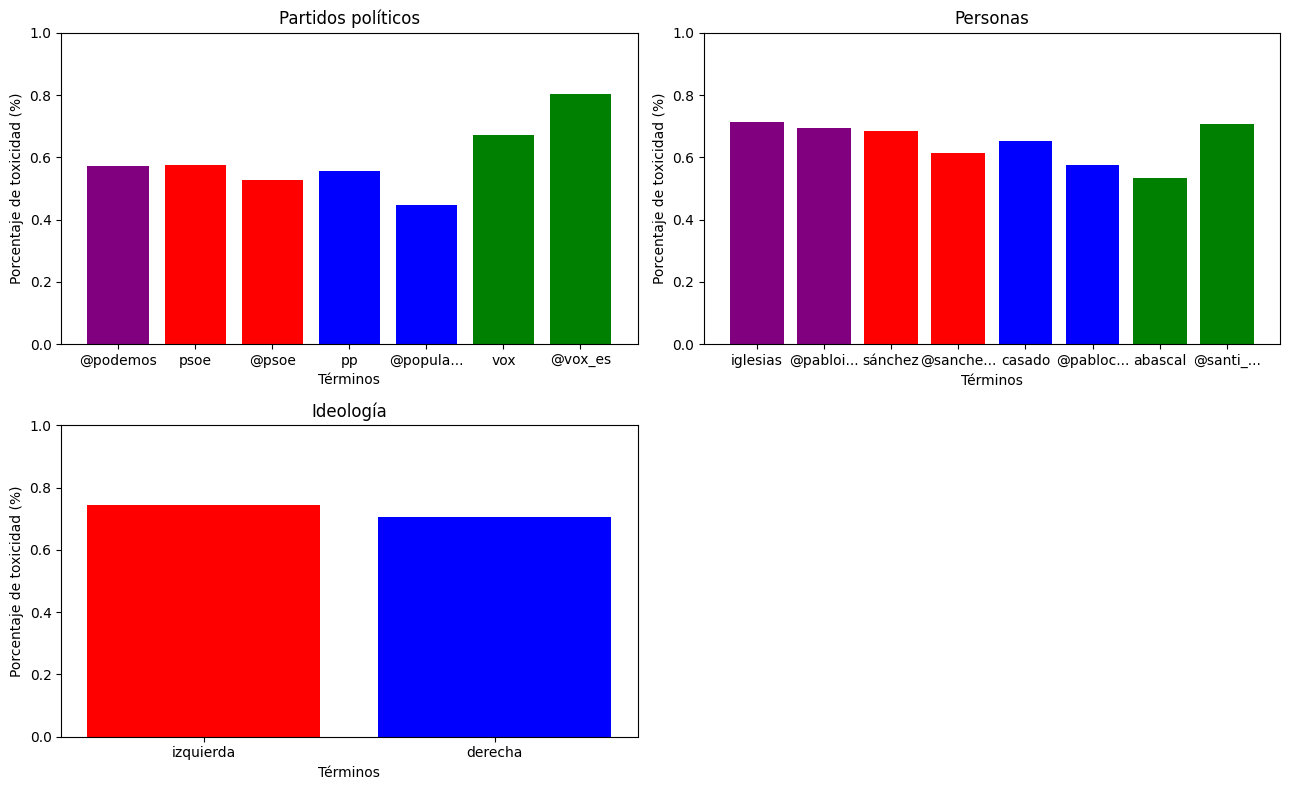

In [30]:
# Define the three plots
plots = {
    'Partidos pol√≠ticos': {
        'terms': ['@podemos', 'psoe', '@psoe', 'pp', '@populares', 'vox', '@vox_es'],
        'colors':  ['purple', 'red', 'red', 'blue', 'blue', 'green', 'green']
    },
    'Personas': {
        'terms': ['iglesias', '@pabloiglesias', 's√°nchez', '@sanchezcastejon', 'casado', '@pablocasado', 'abascal', '@santi_abascal'],
        'colors':  ['purple', 'purple', 'red', 'red', 'blue', 'blue', 'green', 'green']
    },
    'Ideolog√≠a': {
        'terms': ['izquierda', 'derecha'],
        'colors':  ['red', 'blue']
    },
}

# Make a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))
for i, (label, values) in enumerate(plots.items()):
    toxicity_ratio = [global_frequencies_train[TOXIC][term] for term in values['terms']]
    # Truncate long names to avoid visual overflow on the plots
    term_names = [name if len(name) < 10 else f"{name[:10-len('...')]}..." for name in values['terms']]

    ax = axes[i // 2, i % 2]
    ax.bar(term_names, toxicity_ratio, color=values['colors'])
    ax.set_xlabel('T√©rminos')
    ax.set_ylabel('Porcentaje de toxicidad (%)')
    ax.set_title(label)
    ax.set_ylim(0, 1)

# Hide the fourth axis
axes[1, 1].axis('off')

# Show plots
plt.tight_layout()
plt.show()

He considerado a los cuatro principales partidos pol√≠ticos a nivel nacional y sus l√≠deres pol√≠ticos de la √©poca de la pandemia:
- Pablo Iglesias (Podemos)
- Pedro S√°nchez (PSOE)
- Pablo Casado (PP)
- Santiago Abascal (Vox)

Ni Yolanda D√≠az ni Feij√≥o son figuras pol√≠ticas relevantes en estos datos de entrenamiento.

En cuanto a los resultados, se puede observar que:
- <u>La toxicidad est√° m√°s centrada en ataques hacia los pol√≠ticos que hacia los propios partidos</u>.
- A nivel de partido, la toxicidad se concentra alrededor de Vox, como hab√≠amos visto previamente.




###Ejemplos de mensajes t√≥xicos

In [31]:
import re
from IPython.display import display, HTML

In [32]:
# Show examples of toxic messages in a visual way (using material design cards)
# First, define the card style

style = """
<style>
.material-card {
    box-shadow: 0 4px 8px 0 rgba(0,0,0,0.2);
    transition: 0.3s;
    border-radius: 10px;
    padding: 15px;
    margin-bottom: 20px;
    background-color: #fff;
}

.card-title {
    color: #06c2c2;
    font-size: 18px;
    margin-bottom: 10px;
    font-weight: bold;
}

.card-content {
    color: #333;
}
</style>
"""
cards_html = ""

# Select a list of TOP10 toxic words according to our analysis
most_toxic_words = ['miserable', 'verg√ºenza', 'progre', 'golpista', 'sectario',
                    'ruina', 'separatista', 'comunista', 'mafia', 'miseria']

for word in most_toxic_words:
    # Filter the toxic (label 1) rows that contain such word
    filtered_rows = df_train_val[(df_train_val['text'].str.contains(
        fr"\b{word}\b", na=False, regex=True)) & (df_train_val['label'] == 1)]

    if not filtered_rows.empty:  # If there's some match
        example_text = filtered_rows['text'].iloc[0]

        # Highlight the matching word (independently of the casing)
        bolded_word = fr"<b>{word}</b>"
        example_text_bolded = re.sub(fr"\b{word}\b", bolded_word, example_text,
                                     flags=re.IGNORECASE)

        # Append the toxic message to the card
        cards_html += f"""
        <div class="material-card">
            <div class="card-title">{word.upper()}</div>
            <div class="card-content">{example_text_bolded}</div>
        </div>
        """
    else:  # Otherwise, show a standard message
        cards_html += f"""
        <div class="material-card">
            <div class="card-title">{word.upper()}</div>
            <div class="card-content">No se encontraron coincidencias.</div>
        </div>
        """

# Combine HTML and CSS segments and display the cards
display(HTML(style + cards_html))

Los ejemplos muestran mensajes de ambas corrientes pol√≠ticas, aunque es cierto que la corriente conservadora es mayoritaria (7 de 10). Independientemente de la orientaci√≥n pol√≠tica, **la gran mayor√≠a de mensajes parecen estar relacionados con Vox o han asimilado su discurso**, por lo que, como ven√≠amos viendo, este partido parece ser la fuente principal de toxicidad en Twitter en el ciclo pol√≠tico actual:
- <u>Mensajes de Vox o apoyo de sus simpatizantes (menci√≥n directa)</u>: "verg√ºenza", "progre", "separatista", "comunista", "mafia".
- <u>Ataques a Vox</u>: "golpista".
- <u>Mensajes con el mismo discurso que Vox</u> (_derecha alternativa_): "sectario", "ruina".

Se trata de un <u>discurso muy f√°cilmente identificable</u> (polarizante y simplista [creaci√≥n de bandos enfrentados e irreconciliables de buenos y malos]) <u>que abusa de descalificativos con marcado corte pol√≠tico que son adem√°s muy caracter√≠sticos</u> (progre, comunista, etc) <u>y con "enemigos" claros</u> (los partidos de "izquierdas", los nacionalismos perif√©ricos [en el caso particular de Espa√±a], los inmigrantes musulmanes y el feminismo).

#Preprocesado de los datos

Ahora vamos a proceder a hacer un **simple preprocesado** de los datos de entrenamiento y _test_. La limpieza llevada a cabo previamente para solucionar los problemas de decodificaci√≥n se puede considerar tambi√©n parte del preprocesado, pero se realiz√≥ con anterioridad para facilitar el an√°lisis del contenido sem√°ntico de los datos. Este preprocesado consiste en las siguientes acciones:
- <u>Sustituci√≥n de los saltos de l√≠nea</u> (\n) <u>por espacios</u>.
- <u>Eliminaci√≥n de todos los emojis</u>. A pesar de que estos s√≠ que tienen significado sem√°ntico, no es com√∫n que aparezcan en los vocabularios de los modelos de NLP (tal y como sucede en el modelo que emplear√© para esta tarea), lo cual no hace otra cosa que a√±adir ruido en forma de tokens \<unk>.
- <u>Eliminaci√≥n de las URL de Twitter que empiezan por "https://t.co/"</u>. Se trata de URL sin ning√∫n tipo de informaci√≥n sem√°ntica (no contienen palabras).

Me he ayudado de la librer√≠a cleantext para los dos primeros puntos.

In [33]:
from cleantext import clean
from toxicity_analysis.utils.constants import TWITTER_REGEX

In [34]:
text_columns = [TEXT, ENGLISH, FRENCH]  # Target columns (og text and their translations)

# Define cleantext preprocessing function.
# Ensure that undesired default parameters are set to False
remove_line_breaks_emojis = lambda text: clean(text, fix_unicode=False, to_ascii=False, lower=False,
                                               no_line_breaks=True, strip_lines=False, no_emoji=True) if text is not NA else NA

# Create new train/test DataFrames with the preprocessed texts
# to maintain their "raw" versions separated
df_train_val_prepro, df_test_prepro = df_train_val.copy(), df_test.copy()

for column in text_columns:  # Apply the preprocessing
    df_train_val_prepro[column] = df_train_val_prepro[column].str.replace(TWITTER_REGEX, '', regex=True).apply(remove_line_breaks_emojis).astype('string')
    df_test_prepro[column] = df_test_prepro[column].str.replace(TWITTER_REGEX, '', regex=True).apply(remove_line_breaks_emojis).astype('string')

In [35]:
style_dataframe(df_train_val_prepro)

In [36]:
style_dataframe(df_test_prepro)

Comprobamos que el preprocesado ha funcionado correctamente.

#Creaci√≥n de los datasets de _train_, _validation_ y _test_

A pesar de que la cantidad de datos de entrenamiento es m√°s bien limitada (11.000 filas; 30.919 textos en total si contamos las traducciones a ingl√©s y franc√©s que no son _missing values_), **siempre es recomendable reservarse un _split_ de validaci√≥n para asegurarse durante el entrenamiento que nuestro modelo est√° generalizando correctamente y detectar cu√°ndo se produce el _overfitting_**.

Dicho _split_ de validaci√≥n se obtiene de forma aleatoria de los datos de entrenamiento antes de mezclar todos los textos independientemente del idioma, asegur√°ndonos de que textos con el mismo contenido sem√°ntico no se mezclan en distintos _splits_ (_data leakage_). Tras esto, procedemos a crear una entrada del dataset por texto siempre que este no constituya un _missing value_. Los dataset tienen por tanto s√≥lo las columnas "text" y "label".

Se definen tambi√©n <u>datasets segmentados por idioma</u> para realizar luego pruebas de rendimiento por idioma.

In [37]:
from sklearn.model_selection import train_test_split
from toxicity_analysis.utils.constants import COLUMN_TO_LANG, TRAIN, VAL, TEST

In [38]:
# Split before merging languages to avoid any data leakage
# Validation size: 10% of the training data
df_train_prepro, df_val_prepro = train_test_split(df_train_val_prepro, test_size=0.1, random_state=0, shuffle=True)

# As we want to achieve a language-agnostic model, we create a unique "text"
# variable with the contents of the previous "text", "english" and "french" variables,
# ignoring all missing values ('single_language_datasets').

# In both cases (all/single languages), they're defined as dictionaries
# whose keys are the name of the data split: train, val, test
datasets, single_language_datasets = {}, {}

# Iterate over each data split
for df_prepro, dataset_name in zip((df_train_prepro, df_val_prepro, df_test_prepro), (TRAIN, VAL, TEST)):

  # Single-language datasets are two-level dictionaries -> data split -> language
  single_language_datasets[dataset_name] = {COLUMN_TO_LANG[language]:
                                            df_prepro[[language, LABEL]].copy().dropna().rename(columns={language: TEXT})
                                            for language in text_columns}

  # For simplification, all-language data splits are obtained via single-language datasets concatenation
  datasets[dataset_name] = pd.concat(single_language_datasets[dataset_name].values(), axis=0, ignore_index=True)

  # [Sanity check] Make sure that data types of both variables is correct
  assert datasets[dataset_name][LABEL].dtype == 'uint8', f"Label dtype was expected to be uint8. Got {datasets[dataset_name][LABEL].dtype}"
  assert datasets[dataset_name][TEXT].dtype == 'string', f"Text dtype was expected to be string. Got {datasets[dataset_name][TEXT].dtype}"


# Create independent variables for each data split
train_dataset, val_dataset, test_dataset = datasets[TRAIN], datasets[VAL], datasets[TEST]

assert train_dataset.shape[-1] == val_dataset.shape[-1] == test_dataset.shape[-1] == 2, f"All datasets must have 'text' and 'label' columns only."

Comprobamos que el formato de los diferentes _splits_ es el correcto y que su tama√±o es el esperado (27.853 + 3.066 = 30.919 OK).

In [39]:
style_dataframe(train_dataset)

In [40]:
print(train_dataset.shape)

(27853, 2)


In [41]:
style_dataframe(val_dataset)

In [42]:
print(val_dataset.shape)

(3066, 2)


In [43]:
style_dataframe(test_dataset)

In [44]:
print(test_dataset.shape)

(14977, 2)


## Evaluaci√≥n inicial del modelo preentrenado

Antes de definir la _pipeline_ de entrenamiento de nuestro modelo preentrenado, vamos a probar <u>qu√© tal funciona el modelo elegido directamente en los datos de validaci√≥n para cada idioma</u>. No utilizo los datos de _test_ porque estos se deben reservar para la evaluaci√≥n final ni tampoco los datos de entrenamiento porque es a los que se ajustar√° el modelo en el proceso de _fine-tuning_.

El modelo elegido ha sido **lxyuan/distilbert-base-multilingual-cased-sentiments-student** (HuggingFace). ¬øPor qu√©?
- Al tratarse de una tarea de clasificaci√≥n, no necesitamos un modelo que posea un _decoder_ (no vamos a generar texto, s√≥lo necesitamos un modelo que sea capaz de capturar la informaci√≥n de los textos), por lo que un modelo <u>_encoder-only_</u> es la mejor soluci√≥n.
- Actualmente, el modelo _encoder-only_ de referencia (SoTA) es <u>BERT</u>.
- Como tenemos una cantidad de datos de entrenamiento muy reducida y adem√°s la cantidad de c√≥mputo gratuita que ofrece Google Colab es bastante limitada, seleccionamos la <u>versi√≥n m√°s ligera que existe actualmente de BERT: DistilBERT</u> (135M de par√°metros).
- Es mucho m√°s prioritario que <u>el modelo comprenda tanto el espa√±ol, como el ingl√©s y el franc√©s</u> a que sepa realizar la tarea de detecci√≥n de toxicidad; ya que esta se puede adaptar a partir de una similar mucho m√°s f√°cilmente que tener que entrenar los _embeddings_.
- Es aqu√≠ donde llegamos a la elecci√≥n de distilbert-base-multilingual-cased-sentiments-student, ya que (1) es un modelo DistilBERT (2) comprende 12 idiomas (entre ellos espa√±ol, ingl√©s y franc√©s) (3) fue entrenado para la tarea de _sentiment analysis_, una tarea de clasificaci√≥n que guarda bastantes similitudes con la detecci√≥n de toxicidad.

Lo he implementado todo en <u>PyTorch</u> por ser la librer√≠a nativa de HuggingFace.

In [45]:
import torch
from torch.utils.data import DataLoader
from warnings import warn

from toxicity_analysis.utils.constants import MODEL_NAME, MODEL_MAX_LENGTH
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Warn when GPU is not available (pretty common)
if not torch.cuda.is_available():
    warn("Running PyTorch in CPU")
else:  # Check CUDA config (if GPU is available)
  !nvidia-smi

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")

Wed Nov 29 02:01:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
# Function to tokenize every text chain that arrives to the model
# within a batch (collate_fn of the DataLoader that generates the batches)
def tokenize_batch(batch):
    return tokenizer(batch, padding=True, truncation=True, max_length=MODEL_MAX_LENGTH, return_tensors="pt")

model_name = MODEL_NAME
batch_size = 64

# Load model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained(model_name)
model.to(device)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# 'sort_val_set_by_lang' is a dictionary that store each (text, label) pair
# filtered by their language. The items are ordered by texts' length
# in ascending order for a faster inference
sort_val_set_by_lang = {lang: dataset.copy().sort_values(by=TEXT, key=lambda x: x.str.len())
                                     for lang, dataset in single_language_datasets[VAL].items()}

# Store model's predictions by language (same structure as 'sort_val_set_by_lang')
predictions_by_lang = {lang: [] for lang in single_language_datasets[VAL]}

with torch.no_grad():
    for lang, lang_set in sort_val_set_by_lang.items():  # Iterate over each language
        # Create a DataLoader to manage correctly the batching
        data_loader = DataLoader(lang_set[TEXT].tolist(), batch_size=batch_size, collate_fn=tokenize_batch)
        # Iterate over each batch (TQDM to see progress -> it takes time)
        for batch in tqdm(data_loader, desc=f"Processing results ({lang.title()})"):
            batch = batch.to(device)
            logits = model(**batch).logits  # Get model's output
            # Apply softmax function to get the most probable output
            scores = torch.nn.functional.softmax(logits, dim=1).tolist()
            predictions_by_lang[lang].extend(scores)  # Store prediction


config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

Processing results (French): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:02<00:00,  7.97it/s]


In [47]:
import numpy as np
from scipy.stats import pearsonr

from toxicity_analysis.utils.analysis_utils import show_toxicity_vs_sentiment_confusion_matrix

A continuaci√≥n se muestra una **matriz de confusi√≥n** para cada idioma con los resultados de la inferencia del modelo seg√∫n el _label_ del texto de entrada. As√≠ podremos estimar el punto de partida del modelo.

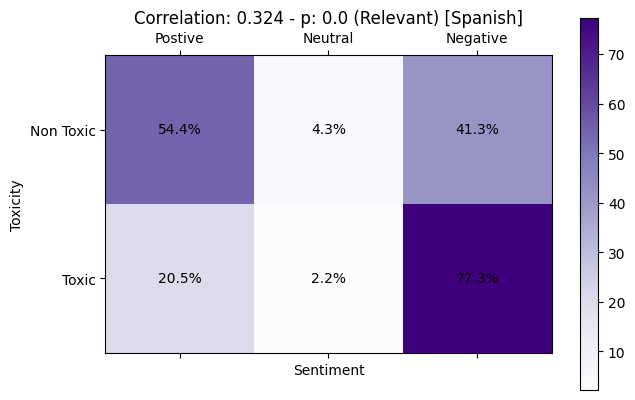

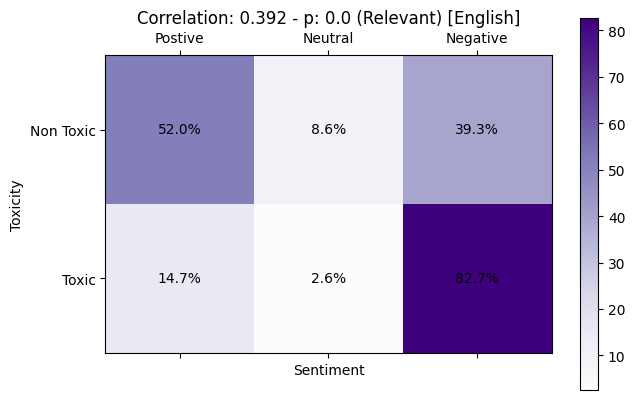

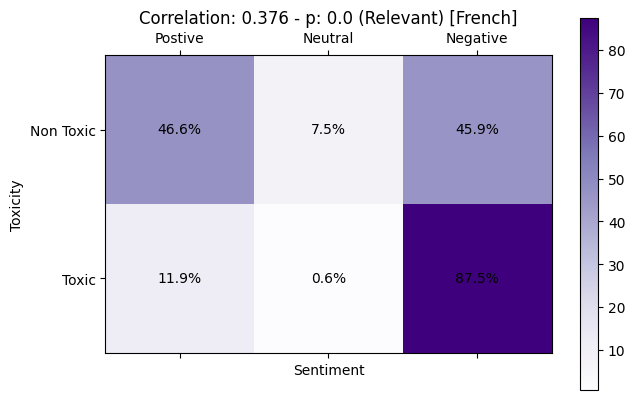

In [48]:
 # Iterate over each validation set entry
for lang, toxicity_dataset in sort_val_set_by_lang.items():
    toxicity_labels = list(toxicity_dataset[LABEL])  # Get entry labels
    # Get sentiment analysis model's predictions (both follow the same order)
    sentiment_labels = list(np.argmax(predictions_by_lang[lang], axis=1))
    assert len(toxicity_labels) == len(sentiment_labels), f"The number of inputs and predictions must be the same"

    # Calculate the Pearson correlation to test the strength in the relationship
    # between both variables. Our hypothesis is that there is a positive relation,
    # this is, that toxicity is related to negative sentiments
    pearson, hipothesis_p_value = pearsonr(x=toxicity_labels, y=sentiment_labels, alternative='greater')

    # Define the title of the plot
    p_explanation = 'Relevant' if hipothesis_p_value < 0.001 else 'Irrelevant'
    pearson_explanation = f"Correlation: {round(pearson, ndigits=3)} - p: {round(hipothesis_p_value, ndigits=5)} ({p_explanation})"

    # Plot the result
    show_toxicity_vs_sentiment_confusion_matrix(toxicity_labels=toxicity_labels,
                                                sentiment_labels=sentiment_labels,
                                                title=f"{pearson_explanation} [{lang.title()}]")

Los resultados muestran que existe una **correlaci√≥n moderada entre las variables de toxicidad y an√°lisis de sentimientos**, lo cual es el punto de partida que busc√°bamos cuando se elegi√≥ este modelo:
- Parece ser que el modelo <u>funciona bastante mejor en los idiomas ingl√©s y franc√©s que en espa√±ol</u>. En ambos casos, clasifica los textos t√≥xicos con sentimientos negativos en +80% de los casos; mientras que en espa√±ol desciende al 77%.
- Se ve claramente que <u>el reto se va a encontrar en los textos no t√≥xicos</u>, ya que el modelo lo clasifica 50/50 (aprox) como positivos o negativos. Al tener los textos no t√≥xicos principalmente un enfoque informativo, parece ser que influye bastante el contenido mismo de la noticia.

# Entrenamiento del modelo

El entrenamiento mediante _fine-tuning_ del ya mencionado modelo lxyuan/distilbert-base-multilingual-cased-sentiments-student consta de las siguientes caracter√≠sticas [para mayor detalle de la implementaci√≥n, mirar los comentarios]
:
- Se le pasan los datos en <u>batches de 64</u> (m√°ximo permitido por los recursos disponibles).
- Dichos datos se <u>aleatorizan al inicio de cada _epoch_</u>.
- Una _epoch_ consiste de una secci√≥n de entrenamiento y otra de validaci√≥n. El <u>criterio de parada se define seg√∫n la _loss_ de los datos de validaci√≥n</u>, pero se _trackea_ tanto la precisi√≥n como la _loss_ de ambos dataset en tiempo real (para cada _training step_).
- Se guarda el hist√≥rico de ambas m√©tricas as√≠ como el mejor valor hasta la fecha para ambos _splits_ en un fichero JSON y tambi√©n un <u>_checkpoint_ por _epoch_</u> (tanto pesos como modelo completo). Ambos los guardo en Google Drive para evitar perder estos ficheros debido a alg√∫n reinicio de sesi√≥n inesperado.
- El <u>optimizador</u> elegido ha sido <u>AdamW</u>, que es la versi√≥n regularizada (permite reducir el _overfitting_) del optimizador m√°s com√∫nmente empleado entre los adaptativos, muy √∫tiles por actualizar din√°micamente la _learning rate_ sin mayor indicaci√≥n que el valor inicial (5e-5 en este caso, muy peque√±a por la propia naturaleza del _fine-tuning_).
- La <u>funci√≥n de _loss_</u> empleada es la <u>_logistic regression_</u> con pesos inversamente proporcionales al balanceo de clases. Se trata de la funci√≥n com√∫nmente utilizada al enfrentarse a una tarea de clasificaci√≥n binaria.
- Se ha ajustado el <u>n√∫mero de clases</u> a predecir por el modelo a <u>dos</u>.
- <u>Se ha congelado la capa de _embeddings_ del modelo en todos los experimentos</u>, ya que no nos interesa que modifique el significado de los tokens de un vocabulario tan extenso cuando tenemos un dataset tan reducido (generalizar√≠a peor).
- Debido a los <u>problemas de _overfitting_</u>, se han realizado distintos experimentos <u>congelando diversos bloques de Transformer para reducir el n√∫mero de par√°metros que debe optimizar</u> (y por tanto la complejidad del modelo).

**Creaci√≥n del objeto Dataset**

In [49]:
from torch.utils.data import Dataset

In [50]:
# Define the Dataset object
class ToxicityDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_length=MODEL_MAX_LENGTH):
        self._dataframe = dataframe  # Data split with "text" and "label" columns
        self.max_length = max_length  # Maximum model lenght (tokens)
        self.input_ids, self.attention_mask = [], []

        # Tokenize at __init__ to save time at training
        for text in dataframe[TEXT]:
            encoding = tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length,
                                               padding='max_length', truncation=True, return_tensors='pt')

            # Encoder-only models don't require decoder inputs (only input_ids and attention_masks)
            input_ids, attention_masks = encoding['input_ids'][0], encoding['attention_mask'][0]
            self.input_ids.append(input_ids)
            self.attention_mask.append(attention_masks)

        # Get labels of each entry for the loss function computation
        self.labels = torch.tensor(dataframe[LABEL], dtype=torch.int64)

        assert len(self.input_ids) == len(self.attention_mask) == len(self.labels)\
               == len(self._dataframe), "Lengths mismatch."

    def __len__(self):
        # Needed for batching and epoch estimations
        return len(self._dataframe)

    def __getitem__(self, idx):
        assert idx <= len(self._dataframe), f"Trying to access idx {idx} in a dataset of size {len(self._dataframe)}"

        # In HuggingFace models, inputs are provided as dictionaries
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

**Definici√≥n del proceso de entrenamiento y evaluaci√≥n para cada _epoch_**

In [51]:
# Define the training / validation process of each epoch (it has two modes)
def process_epoch(model, data_loader, loss_fn, device,
                  mode='train', optimizer=None, scheduler=None):

    assert mode in ('train', 'eval'), f"Mode must be 'train' or 'eval', got {mode} mode."

    # Set the correct mode in the model, since during evaluation we don't need
    # as much resources as during training
    if mode == 'train':
        assert optimizer is not None and scheduler is not None, f"Missing optimizer and/or scheduler during training."
        model.train()
    else:
        model.eval()

    losses, corrects = [], 0  # Loss and accuracy metrics

    # Using TQDM as a 'with' instead of a 'for' to see the progress of
    # loss and accuracy metrics dynamically during training and evaluation
    with tqdm(total=len(data_loader), desc=f"{mode.title()} progress") as progress:
        for i, d in enumerate(data_loader):  # For each batch

            # Get inputs
            input_ids, labels = d["input_ids"].to(device), d["labels"].to(device)
            attention_masks = d["attention_mask"].to(device)

            # Set no_grad when evaluating the model (don't compute gradients)
            with torch.set_grad_enabled(mode=='train'):
                if mode == 'train':
                    outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
                else:
                    outputs = model(input_ids=input_ids, attention_mask=attention_masks)

                # Compute loss for this batch
                loss = loss_fn(outputs.logits, labels)
                losses.append(loss.item())

                # Compute accuracy for this batch
                corrects_count = torch.sum(torch.argmax(outputs.logits, dim=1) == labels)
                corrects += corrects_count.item()

                # Update loss optimizer and learning rate scheduler
                if mode == 'train':
                    optimizer.zero_grad()
                    loss.backward()  # Backpropagation
                    optimizer.step()
                    scheduler.step()

                progress.update(1)  # Update TQDM's loss and accuracy metrics
                progress.set_description(f"{mode.title()}. Loss: {round(sum(losses)/len(losses), ndigits=4)}."\
                                         f" Acc: {round((corrects/((i+1)*data_loader.batch_size))*100, ndigits=3)}%")

    # Get final mean loss and accuracy metrics for this epoch
    accuracy = corrects / len(data_loader.dataset)
    mean_loss = sum(losses) / len(losses)

    return accuracy, mean_loss

**Parametrizaci√≥n del entrenamiento y definici√≥n de los diferentes experimentos**

In [52]:
import math
import json

from sklearn.utils.class_weight import compute_class_weight
from transformers import get_linear_schedule_with_warmup

from torch.utils.data import Sampler
from torch.optim import AdamW

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warn("Running training in CPU")
else:
    # Empty the CUDA cache if using GPU
    torch.cuda.empty_cache()

# Batch size 32 is the maximum possible with *GPU* Colab resources
NUM_EPOCHS, BATCH_SIZE = 40, 64

tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Define train and validation datasets. Shuffle them at the beginning of each epoch
training_set = ToxicityDataset(dataframe=train_dataset, tokenizer=tokenizer)
train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

validation_set = ToxicityDataset(dataframe=val_dataset, tokenizer=tokenizer)
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True)

In [54]:
from toxicity_analysis.utils.constants import CHECKPOINT_PATHS, ONLY_FREEZE_EMBEDDINGS, FREEZE_ALL_TRANSFORMER_LAYERS_EXCEPT_LAST, FREEZE_ALL_TRANSFORMER_LAYERS

# Since the model is big (135M) and the training data is scarce, the model tends
# to overfit fast (at the 3rd epoch usually). At the beginning, I only planned
# to freeze the embeddings layer (to not lose the broad knowledge of such
# a big vocabulary [+100K tokens] to a very specific scope of content and languages),
# but I also tested freezing different Transformer blocks to see if a reduced
# number of parameters to be trained would result in a better generalization

EXPERIMENT = FREEZE_ALL_TRANSFORMER_LAYERS

# We use different checkpoint paths for each one of the experiments
assert EXPERIMENT in CHECKPOINT_PATHS, f"Available experiments are {list(CHECKPOINT_PATHS.values())}. Got {EXPERIMENT}."
checkpoint_dir = CHECKPOINT_PATHS[EXPERIMENT]

full_model_path = os.path.join(checkpoint_dir, f"full_model_last.pt")
metrics_json_path = os.path.join(checkpoint_dir, "metrics.json")

if not os.path.isfile(full_model_path):  # Start fine-tuning (no checkpoint found)
    # Note that we changed the number of labels to two instead of three
    model = DistilBertForSequenceClassification.from_pretrained(
        model_name, num_labels=2, ignore_mismatched_sizes=True)
    last_metrics = {}
else:
    # If some checkpoint was found, load it on the target device
    model = torch.load(full_model_path, map_location=device)
    with open(metrics_json_path, "r") as f:
      last_metrics = json.load(f)

# Always freeze the embeddings (independently of the experiment)
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

# Freeze also the Transfomer blocks if required
if EXPERIMENT in (FREEZE_ALL_TRANSFORMER_LAYERS_EXCEPT_LAST, FREEZE_ALL_TRANSFORMER_LAYERS):
    trans_layers = len(model.distilbert.transformer.layer)  # Get Transformer layers
    layers_to_freeze = 1 if EXPERIMENT == FREEZE_ALL_TRANSFORMER_LAYERS_EXCEPT_LAST else 0
    print(f"Freezed {trans_layers-layers_to_freeze} of {trans_layers} transformer layers")
    for i in range(trans_layers - layers_to_freeze):  # Freeze them
        for param in model.distilbert.transformer.layer[i].parameters():
            param.requires_grad = False

model = model.to(device)


Freezed 6 of 6 transformer layers


**Definici√≥n del _optimizer_ y _scheduler_**

In [68]:
# The optimizer is the stochastic algorithm that defines the direction
# of the model weights' updates during training in order to optimize the
# loss function and the scheduler defines the high-level progression of the
# learning rate parameter at every training step. This parameter is used
# by the optimizer to estimate how big these updates can be

# We use AdamW with a rather small starting learning rate because of
# doing a fine-tuning training. Why AdamW? Because (1) it's adaptive
# --the learning rate is updated automatically starting from an initial value
# and because (2) it applies L2 regularization (which reduces overfitting)
# It's also the common go-to optimizer and I didn't have much time for
# testing different options or hyperparameters
optimizer = AdamW(model.parameters(), lr=5e-5)

# To avoid problems when resuming checkpoint
for group in optimizer.param_groups:
    group.setdefault('initial_lr', group['lr'])

# Set warmup_steps=0 to start reducing the learning rate since the beginning
# and reduce the risk of overfitting
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=len(train_loader) * NUM_EPOCHS,
                                            last_epoch=last_metrics.get("epochs", 1))

# Weight the the loss function to assess class imbalance
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_dataset['label'].values)
weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

# Cross Entropy (logistic regresstion) is the best
# loss function for *binary* classification
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

**Definici√≥n del proceso de entrenamiento, registro de m√©tricas y condici√≥n de parada**

In [69]:
# Get history of loss and accuracy metrics
train_accs, train_losses = last_metrics.get('train_acc_hist', []), last_metrics.get('train_loss_hist', [])
val_accs, val_losses = last_metrics.get('val_acc_hist', []), last_metrics.get('val_loss_hist', [])
# Get best loss and accuracy to date, the condition to choose the final model
best_val_loss, best_val_loss_epoch = last_metrics.get('best_val_loss', float('inf')), last_metrics.get('best_val_loss_epoch', 0)
val_acc_at_best_loss = last_metrics.get("acc_at_best_loss", None)

SAVE_EVERY, EARLY_STOP_AT = 1, 10

# Iterate over a maximum number of epochs
for epoch in range(last_metrics.get("epochs", 0), NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # -- TRAIN SECTION --
    train_acc, train_loss = process_epoch(mode='train', model = model,
                                          data_loader = train_loader,
                                          loss_fn = loss_fn, optimizer = optimizer,
                                          device = device, scheduler = scheduler)

    train_accs.append(float(train_acc)), train_losses.append(float(train_loss))

    # -- VALIDATION SECTION --
    val_acc, val_loss = process_epoch(mode = 'eval', model = model,
                                      data_loader = validation_loader,
                                      loss_fn = loss_fn, device = device)

    val_accs.append(float(val_acc)), val_losses.append(float(val_loss))

    # The chosen model is the one that reduces the loss
    # on the validation data. These data are unseen by the model
    # and let us know if it's capable of generalizing
    if val_loss < best_val_loss:
      best_val_loss, best_val_loss_epoch = float(val_loss), epoch
      val_acc_at_best_loss = float(val_acc)
      # Save the best model (device-agnostic to ensure compatibility)
      model_to_save = model.to('cpu')
      torch.save(model_to_save.state_dict(), os.path.join(checkpoint_dir, f"best_model.pt"))
      model = model_to_save.to(device)

    # Trigger early stopping when validation loss hasn't improved
    # for "EARLY_STOP_AT" epochs
    elif best_val_loss_epoch + EARLY_STOP_AT < epoch:
      print(f"Early stopping triggered at epoch {epoch}")
      break

    # Save a model checkpoint every "SAVE_EVERY" epochs
    # We save both weights and full-model just in case
    if epoch % SAVE_EVERY == 0:
        model_to_save = model.to('cpu')
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"model_last.pt"))
        torch.save(model, os.path.join(checkpoint_dir, f"full_model_last.pt"))
        model = model_to_save.to(device)

    # Save the metrics to a JSON file at every step
    with open(metrics_json_path, "w") as f:
        json.dump({
            "train_loss_hist": train_losses,
            "train_acc_hist": train_accs,
            "val_loss_hist": val_losses,
            "val_acc_hist": val_accs,
            "best_val_loss": best_val_loss,
            "best_val_loss_epoch": best_val_loss_epoch,
            "acc_at_best_loss": val_acc_at_best_loss,
            "epochs": epoch + 1 # There is one epoch completed at this point
        }, f)

Epoch 4/40


Eval. Loss: 0.3847. Acc: 83.789%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:13<00:00,  3.44it/s]


Epoch 5/40


Eval. Loss: 0.375. Acc: 83.529%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.38it/s]


Epoch 6/40


Eval. Loss: 0.3666. Acc: 83.04%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.38it/s]


Epoch 7/40


Eval. Loss: 0.3656. Acc: 83.659%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.42it/s]


Epoch 8/40


Eval. Loss: 0.3613. Acc: 83.366%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.43it/s]


Epoch 9/40


Eval. Loss: 0.3644. Acc: 84.017%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.43it/s]


Epoch 10/40


Eval. Loss: 0.3638. Acc: 83.691%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.38it/s]


Epoch 11/40


Eval. Loss: 0.3624. Acc: 84.115%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.42it/s]


Epoch 12/40


Eval. Loss: 0.3694. Acc: 84.896%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.38it/s]


Epoch 13/40


Eval. Loss: 0.3536. Acc: 83.626%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.37it/s]


Epoch 14/40


Eval. Loss: 0.3637. Acc: 84.928%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.38it/s]


Epoch 15/40


Eval. Loss: 0.356. Acc: 84.505%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.42it/s]


Epoch 16/40


Eval. Loss: 0.3524. Acc: 84.277%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:13<00:00,  3.43it/s]


Epoch 17/40


Eval. Loss: 0.3552. Acc: 84.863%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.33it/s]


Epoch 18/40


Eval. Loss: 0.3562. Acc: 84.831%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.43it/s]


Epoch 19/40


Eval. Loss: 0.3564. Acc: 84.928%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.42it/s]


Epoch 20/40


Eval. Loss: 0.3532. Acc: 84.961%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.37it/s]


Epoch 21/40


Eval. Loss: 0.353. Acc: 84.277%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:14<00:00,  3.42it/s]


Epoch 22/40


Eval. Loss: 0.3452. Acc: 84.049%: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:13<00:00,  3.43it/s]


Epoch 23/40


Train. Loss: 0.3166. Acc: 86.053%:   6%|‚ñå         | 27/436 [00:08<02:11,  3.11it/s]


KeyboardInterrupt: ignored

#Evaluaci√≥n de los modelos candidatos y selecci√≥n del modelo final

**Curvas de entrenamiento**

Experiment: only_freeze_embeddings


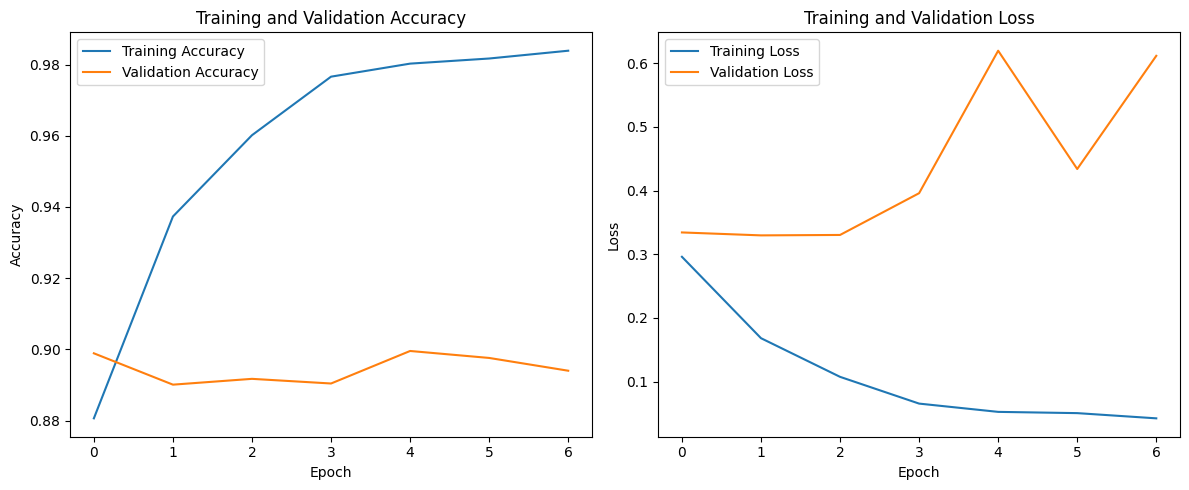

Experiment: freeze_all_transformer_layers_except_last


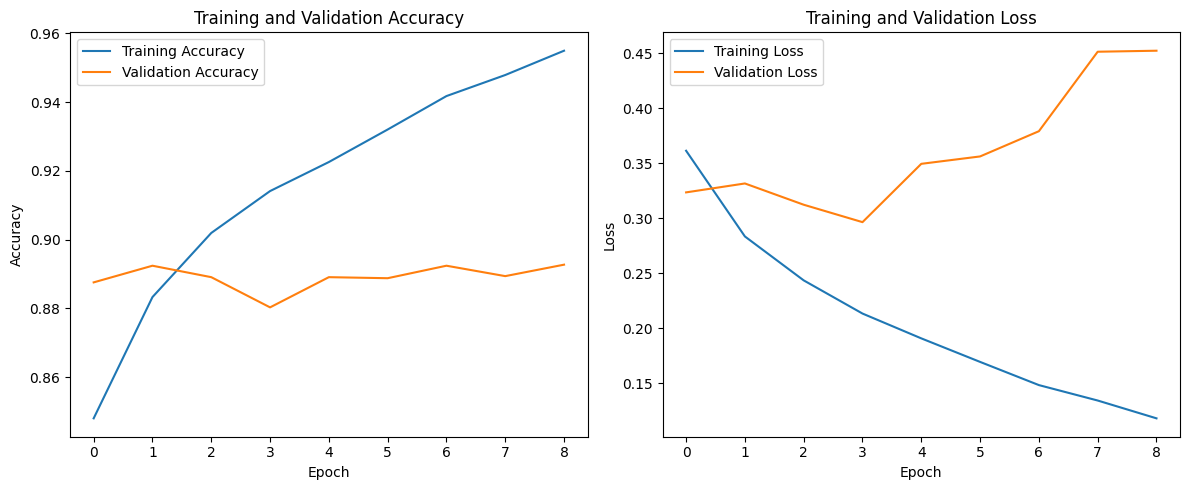

Experiment: freeze_all_transformer_layers


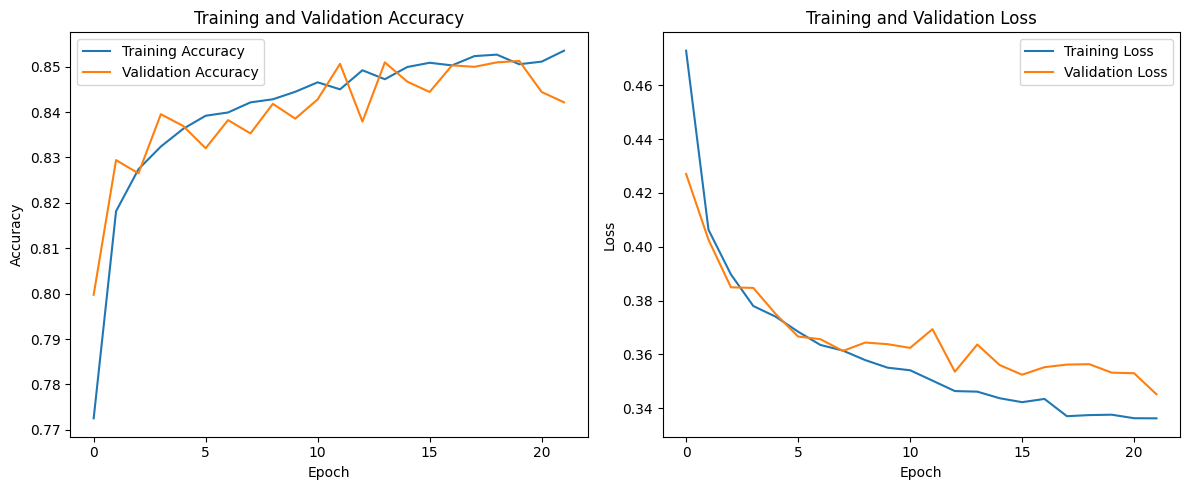

In [55]:
from toxicity_analysis.utils.model_performance_analysis import plot_training_curves
from toxicity_analysis.utils.constants import CHECKPOINT_PATHS, METRICS_JSON_FILE, TRAIN_LOSS_HIST, TRAIN_ACC_HIST, VAL_LOSS_HIST, VAL_ACC_HIST

# Plot training and validation curves for both accuracy and loss metrics
# for each one of the three experiments defined
for experiment_name, experiment_path in CHECKPOINT_PATHS.items():
  with open(os.path.join(experiment_path, METRICS_JSON_FILE), 'r') as f:
    metrics = json.load(f)

  print(f"Experiment: {experiment_name}")
  plot_training_curves(train_accs = metrics[TRAIN_ACC_HIST], train_losses = metrics[TRAIN_LOSS_HIST],
                        val_accs = metrics[VAL_ACC_HIST], val_losses = metrics[VAL_LOSS_HIST],)

Como podemos observar, **el modelo hace _overfitting_ r√°pidamente con el planteamiento original** (congelando s√≥lo la capa de _embeddings_). Esto estaba destinado a suceder, ya que DistilBERT es un modelo bastante grande (135M de par√°metros) y la cantidad de datos de entrenamiento es muy peque√±a (sobre los 30K).

<u>Lo ideal para obtener mejores resultados habr√≠a sido ampliar los datos de entrenamiento</u> (por ejemplo, usando el dataset FredZhang7/toxi-text-3M); pero no he podido probarlo por falta de tiempo. Por tanto, se ha optado por la otra posible v√≠a: <u>reducir la complejidad del modelo congelando diversos bloques de Transformer</u>.

Se puede observar que congelando todos los bloques de Transformer menos el √∫ltimo, <u>la reducci√≥n del sobreajuste es m√≠nima pero el impacto en la progresi√≥n de la precisi√≥n no tanto</u> (la ralentiza tanto que hace que se estanque en valores m√°s bajos). Este efecto se ve todav√≠a m√°s claro cuando se congelan todos los bloques de Transformer del modelo (√∫ltimo experimento). Por tanto, elegiremos como mejor modelo aquel que minimice la _loss_ del plantemiento original, ya que es donde los datos de validaci√≥n alcanzan su precisi√≥n m√°xima.

**Matrices de confusi√≥n**

In [56]:
from toxicity_analysis.utils.model_performance_analysis import predict_with_probabilities
from toxicity_analysis.utils.constants import CHECKPOINT_PATHS, BEST_MODEL, FREEZE_ALL_TRANSFORMER_LAYERS

val_set_by_lang = single_language_datasets[VAL]

# Get best model predictions (for each experiment) for the validation set.
# Set confidence threshold to 0.5. This is the minimum probability to predict
# a text as 'toxic'. This value can be tuned to maximize model's accuracy
# However, due to the very little size of validation data (3K), it is not
# representative enough to fit a precision-recall curve
predictions_by_experiment = {}
for experiment_name, experiment_path in CHECKPOINT_PATHS.items():
    predictions_by_experiment[experiment_name] = predict_with_probabilities(model_path = os.path.join(CHECKPOINT_PATHS[experiment_name], BEST_MODEL),
                                                                      tokenizer = tokenizer,
                                                                      df_by_language=val_set_by_lang,
                                                                      device=device, conf_th = 0.5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at lxyuan/distilbert-base-multilingual-cased-sentiments-student and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting for French: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 31/31 [00:01<00:00, 20.54it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at lxyuan/distilbert-base-multilingual-cased-sentiments-student and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- class

only_freeze_embeddings


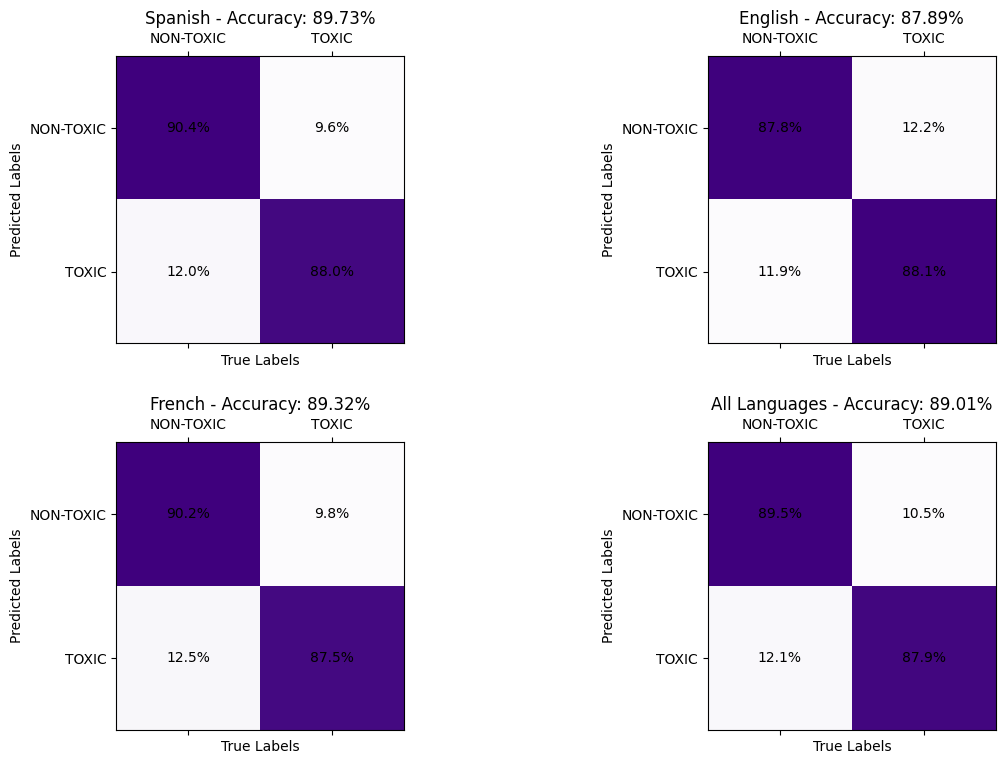

freeze_all_transformer_layers_except_last


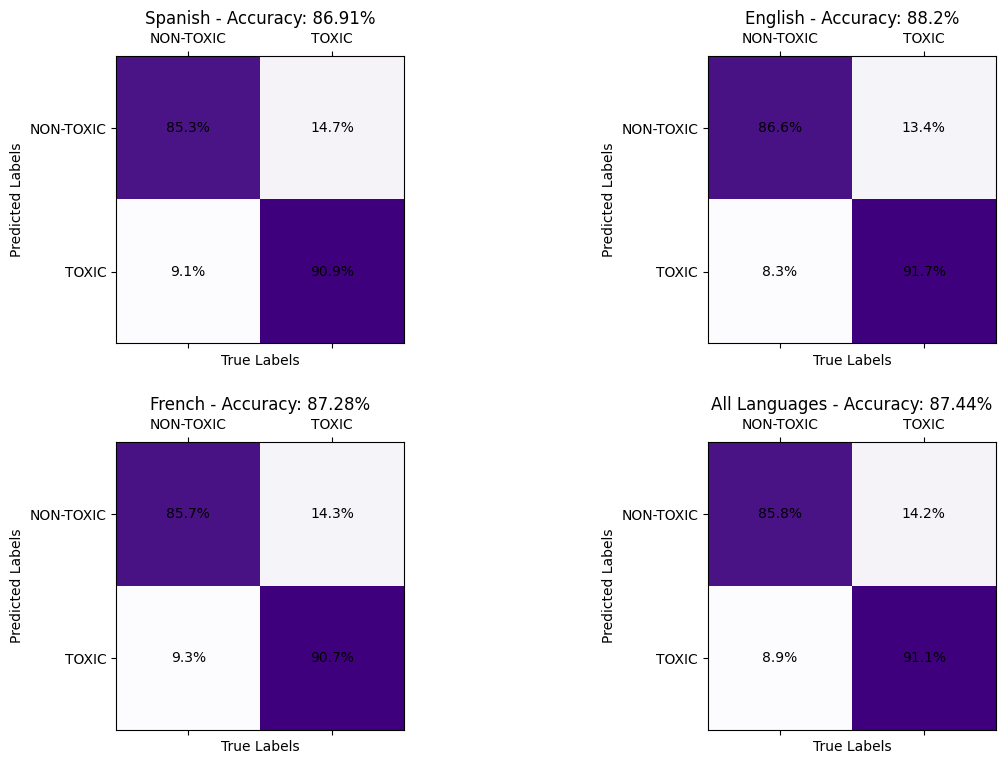

freeze_all_transformer_layers


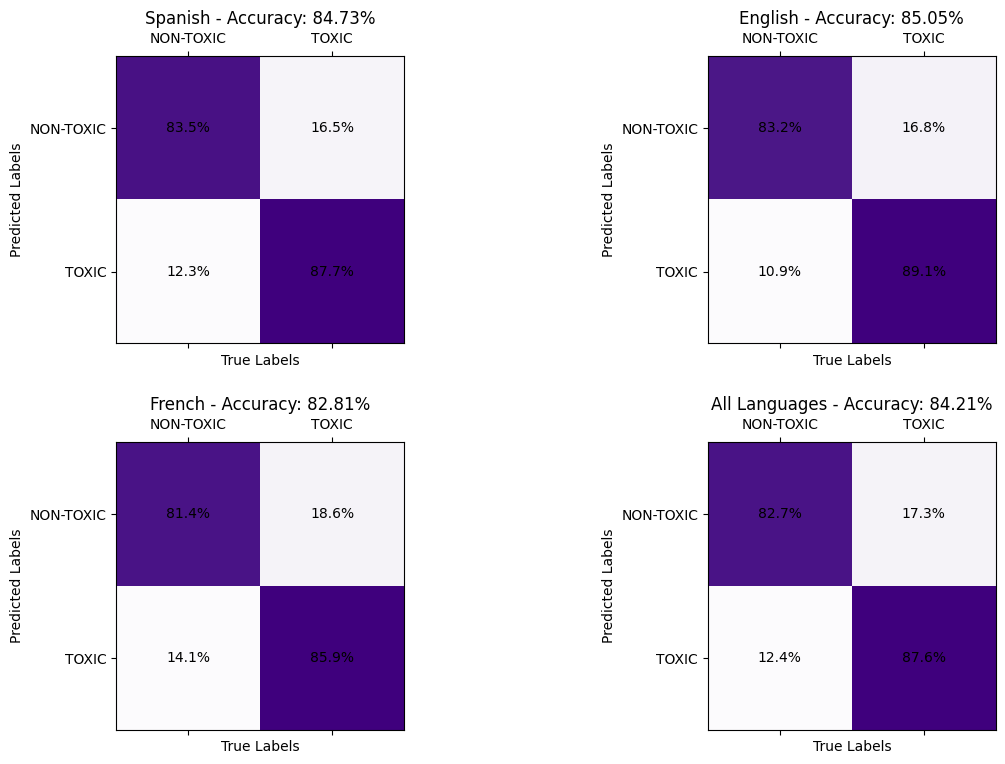

In [57]:
from toxicity_analysis.utils.model_performance_analysis import plot_combined_precision_recall_curve, show_confusion_matrix

# Show the confusion matrices of the best model per experiment
# filtered by language and for all data
for experiment_name, predictions_by_lang in predictions_by_experiment.items():
    print(f"{experiment_name}")
    show_confusion_matrix(labels_and_predictions_by_lang=predictions_by_lang)

Podemos observar que la distribuci√≥n de resultados es muy similar para el mejor modelo de cada uno de los experimentos, pero que **la mayor precisi√≥n se alcanza cuando se congelan s√≥lo la capa de _embeddings_**. Como curiosidad, este es el √∫nico caso en que la clase "toxic" consigue mejores resultados que "non-toxic", aunque tambi√©n es la que muestra unas precisiones m√°s balanceadas.

Notar que, a pesar del alto desbalanceo de las clases en los datos de entrenamiento, <u>se han obtenido precisiones muy similares para ambas clases y adem√°s de forma consistente a lo largo de los diferentes experimentos</u>.

**Curva de _precision-recall_**

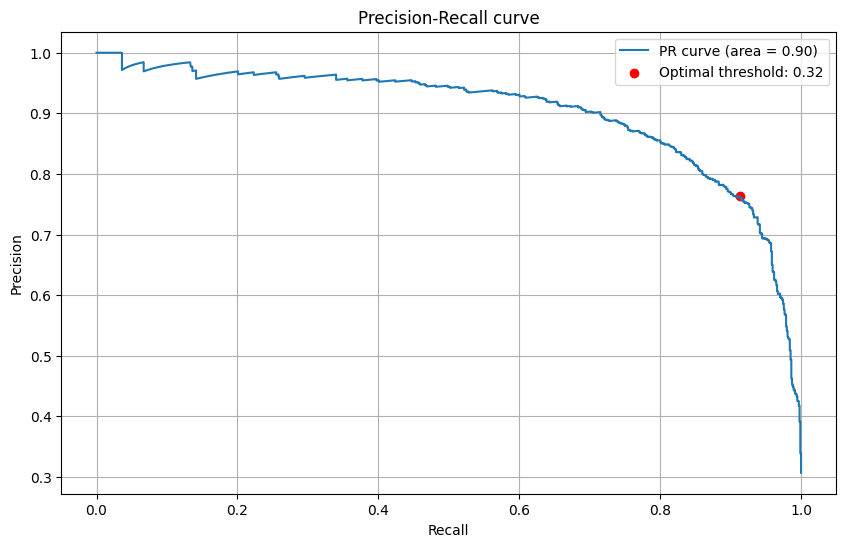

In [58]:
plot_combined_precision_recall_curve(results_by_lang=predictions_by_experiment[ONLY_FREEZE_EMBEDDINGS])

Debido a que las clases de los datos de entrenamiento est√°n muy desbalanceadas, es de inter√©s obtener la curva de _precission-recall_:
- La <u>precisi√≥n</u> mide la proporci√≥n de _true positives_ entre el total de datos. A mayor precisi√≥n, menos _falsos positivos_.
- El <u>_recall_</u> mide la proporci√≥n de _true positives_ entre el n√∫mero de datos con clase _positive_, ya estuvieran correctamente o incorrectamente clasificados por el modelo. A mayor sensibilidad, menos _falsos negativos_.

Una elevada √°rea bajo esta curva (AUC) de _precision-recall_ implica un alto equilibro entre ambas m√©tricas. **Teniendo una AUC de 0.9, podemos afirmar que se trata de un buen modelo para esta tarea de clasificaci√≥n**. Vemos tambi√©n que el _confidence threshold_ √≥ptimo del modelo para los datos de validaci√≥n es de 0.32. Al tratarse de un conjunto tan peque√±o de datos, no considero que sea un valor de referencia como para poder usarlo en la evaluaci√≥n de los datos de _test_, as√≠ que usaremos el est√°ndar 0.5.

#Evaluaci√≥n del modelo final sobre los datos de _test_

**Matrices de confusi√≥n**

In [59]:
# Get TEST data
test_set_by_lang = deepcopy(single_language_datasets[TEST])

checkpoint_path = CHECKPOINT_PATHS[ONLY_FREEZE_EMBEDDINGS]  # Select best model manually
predictions_by_lang = predict_with_probabilities(model_path = os.path.join(checkpoint_path, BEST_MODEL),  # Obtain TEST predictions
                                                 tokenizer = tokenizer, df_by_language=test_set_by_lang, device=device, conf_th = 0.5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at lxyuan/distilbert-base-multilingual-cased-sentiments-student and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting for French: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 156/156 [00:16<00:00,  9.46it/s]


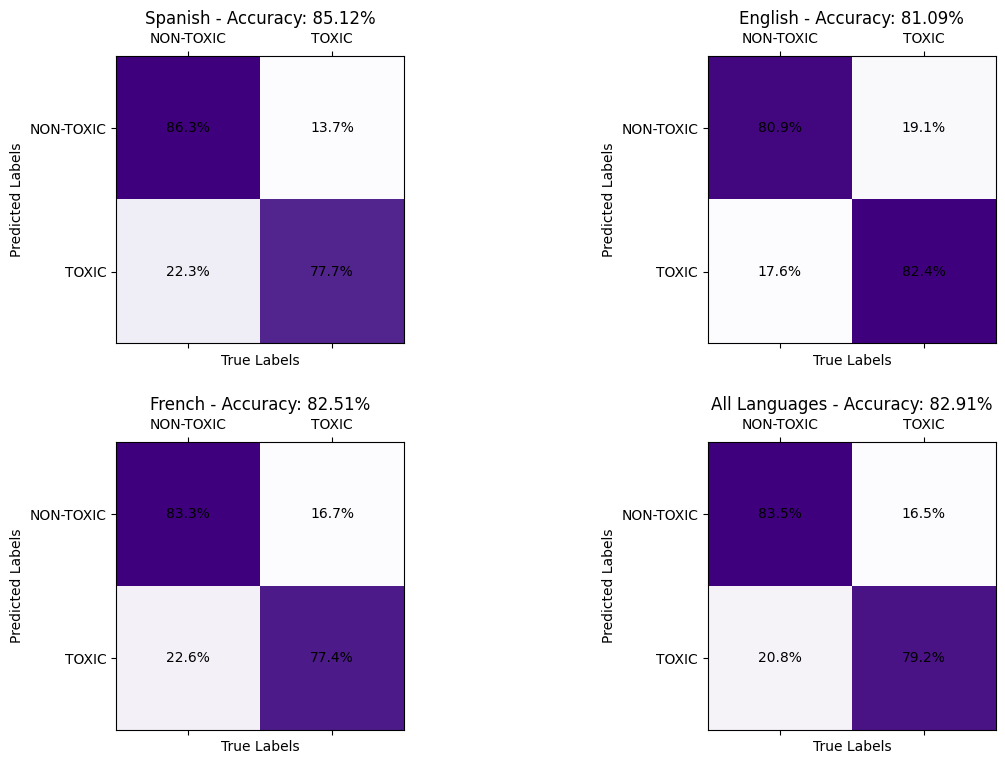

In [60]:
show_confusion_matrix(labels_and_predictions_by_lang=predictions_by_lang)

La distribuci√≥n mostrada en la matriz de confusi√≥n de los datos de _test_ no difiere demasiado de lo ya visto en validaci√≥n. Ya sab√≠amos que la distribuci√≥n de los datos era similar, as√≠ que es un comportamiento esperado. Observaciones:
- Al igual que en validaci√≥n, <u>la precisi√≥n en distintos idiomas difiere ligeramente</u>, pero no se siente desbalanceado. Estas diferencias se deben principalmente a las distancias entre la precisi√≥n de ambas clases, donde vemos que el modelo ingl√©s es el m√°s robusto y en los idiomas espa√±ol y franc√©s hay diferencias m√°s acusadas.
- <u>El modelo predice con mayor precisi√≥n generalmente los mensajes no t√≥xicos que los t√≥xicos</u>, al igual que suced√≠a en validaci√≥n.
- Finalmente, la precisi√≥n general baja ligeramente de 84.2% a 82.9%.

**An√°lisis de sesgos**

In [62]:
from toxicity_analysis.utils.model_performance_analysis import find_top_failures, visualize_top_failures

top_failures = find_top_failures(dataset_by_language=test_set_by_lang, matches_by_language=predictions_by_lang, top_failures=10)
display(visualize_top_failures(top_failures_by_language=top_failures))

En esta √∫ltima secci√≥n de an√°lisis, he seleccionado los diez _falsos positivos_ y los diez _falsos negativos_ con mayor _confindence_ (probabilidad de la clase seleccionada) para ver en qu√© puede estar fallando el modelo en aquellas predicciones de las que est√° m√°s seguro.

---

Analizando los <u>FALSOS POSITIVOS</u>... **Si consideramos "t√≥xicos" aquellos textos llenos de descalificativos y con clara intenci√≥n agresiva, violenta y lesiva**, que es el tipo de mensajes que he podido encontrar en el an√°lisis sem√°ntico de los datos, **no se puede clasificar**...

"S√≥lo en un d√≠a, hemos conocido una tienda de ropa que vende camisetas con elogios a Abascal y amenazas de muerte a Pablo Iglesias y las amenazas tambi√©n de muerte y con dos balas al ex-presidente Zapatero. Condena sin "peros" al **terrorismo fascista** y a los que lo blanquean."

...**como "no t√≥xico"** cuando emplea el t√©rmino "terrorismo fascista".

Lo mismo pasa con el segundo mensaje, que es claramente pasivo agresivo, o el cuarto, que dice "el Gobierno se apoya de socios populistas y nacionalistas". **<u>Todo apunta a que el motivo principal de los falsos positivos en los datos de _test_ sea un etiquetado incorrecto</u>**.

En los casos donde claramente se equivoca (que son minor√≠a), todo apunta a que se debe a que son casos donde se emplean t√©rminos con connotaci√≥n muy negativa:
- "El #4M tenemos una oportunidad hist√≥rica para dar un ejemplo de tolerancia. Os doy mi palabra: jam√°s contribuir√© al **enfrentamiento**. Si no **insult√°is**, votad a quienes no **insultamos** Si respet√°is a quienes piensan distinto, votad a quienes respetamos a todos"
- "Samuel ten√≠a 24 a√±os y toda la vida por delante. Le han dado una **paliza** hasta **matarlo**, por ser gay. Le gritaban "maricon" cada **insulto**, tambi√©n es insulto para todos nosotros. Esto ha ocurrido en el 2021. ¬°Lo han **asesinado**! #justiciaparasamuel"

Al tratarse de un modelo que ha sido _fine-tuneado_ a partir de un modelo pensando para la tarea de **_sentiment analysis_**, no me extra√±a ver que **clasifica como t√≥xicos aquellos mensajes llenos de t√©rminos muy negativos**, sin atender correctamente a los matices, sobre todo cuando la cantidad de datos de entrenamiento es tan peque√±a.

---
En el caso de los <u>FALSOS NEGATIVOS</u>... podemos observar que **<u>claramente no es capaz de detectar las sutilezas que implica la elecci√≥n de ciertas palabras</u>**:
- "Incluso en los momentos m√°s tensos habidos cuando **desgobernaba** un **tipo** llamado Rodr√≠guez Zapatero, hubo puentes y alcantarillas."
- "Sin la moci√≥n de 1980 no hubiera sido posible 1982, de manera que hoy recordar√≠amos 1982 solo por Naranjito y por el Gobierno de Unidad Nacional presidido por el General Armada ‚Äìdel que Felipe fue vicepresidente tercero‚Äì, que tanto hizo por una Espa√±a feliz y unida, **sin mariconadas**, de ah√≠ el mausoleo de Armada, financiado por Endesa y edificado por Calatrava en el hom√≥nimo Valle de Armada, en Armadia, antes provincia de Madrid."

**Tampoco parece hacerlo bien con textos cortos debido a la falta de un mayor contexto**: "Former criminal congressman".

He de mencionar tambi√©n que, aunque mucho menos minoritarios en el caso de los falsos positivos, <u>aqu√≠ tambi√©n hay textos mal clasificados</u>, por ejemplo: "De mantenerse las tasas de natalidad actuales en Espa√±a, en 2055 el tramo quinquenal de edad m√°s numeroso ser√° el 75-79. El 2¬∫ m√°s numeroso, el 80-84. Habr√° m√°s octogenarios que veintea√±eros". @georgina_vox :" no veo que sea t√≥xico.

---

En resumen, a pesar de que el modelo funciona bastante bien, **se deja llevar muy a menudo por el tono y negatividad de los t√©rminos empleados en los textos**. Por ejemplo, no es capaz de clasificar un texto de denuncia que no ataca a nadie como "no t√≥xico" porque contiene t√©rminos como "paliza" o "asesinado"; ni tampoco identificar la toxicidad en mensajes aparentemente neutros y calmados que introducen <u>cr√≠ticas sutiles, especialmente cuando estas s√≥lo aparecen en el _hashtag_</u> (Ejemplo: #PGEdelaRuina, #ParemosSuAgenda).

Para obtener un modelo mucho m√°s robusto, que pueda **comprender con mayor profundidad el contenido y las intenciones de estos mensajes en aquellos casos <u>menos evidentes</u>, debemos emplear un conjunto de datos de entrenamiento √≥rdenes de magnitud m√°s extenso que el actual** (m√≠nimo x10), para permitir que generalice correctamente y pueda hacer una mejor transici√≥n de _sentiment analysis_ a _toxicity detection_. Aun as√≠, <u>los resultados son muy prometedores para disponer de un dataset tan reducido</u>.

Por √∫ltimo, indicar que <u>si los datos no est√°n correctamente etiquetadoss </u>(hay muchos menos textos clasificados como t√≥xicos de los que deber√≠a); <u>no se puede realizar una evaluaci√≥n precisa</u>.

#Cuestiones

**Si tuvieses acceso a un LLMs (ChatGPT, LLaMa, etc, ¬øLo usar√≠as? En caso afirmativo desarrolla la respuesta**

No. Para las tareas de clasificaci√≥n en el √°mbito de NLP no necesitamos arquitecturas con bloque de _decoder_, ya que nuestro objetivo no es generar texto, si no comprender el texto que llega en el input lo mejor posible. Adem√°s, los LLM son modelos enormes como su propio nombre indica (con much√≠simos m√°s par√°metros que el DistilBERT que hemos empleado en este _notebook_); lo cual requiere de una cantidad much√≠simo m√°s grande de datos para obtener un buen resultado. Teniendo en cuenta que necesitamos datos etiquetados para realizar esta tarea (se trata de clasificaci√≥n supervisada), aumentar el tama√±o del dataset de entrenamiento tant√≠simo ser√≠a especialmente costoso.

En resumen, mejor no _matar moscas a ca√±onazos_: la soluci√≥n m√°s sencilla suele ser la mejor opci√≥n.